In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyarrow as pa
import pyarrow.parquet as pq
import statsmodels.api as sm

from pathlib import Path
import glob
import os
#import os
#import zipfile

import epiweeks

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import geopandas as gpd

pd.set_option('display.max_columns', 20)  # or any reasonable number


# Load data

In [2]:
mun_new = list(Path('/opt/storage/refined/aesop/visualization/')
               .glob('aesop_*_mun_new.parquet'))

aesop_mun_new = max(mun_new, key=lambda x: x.stat().st_ctime)

df = pd.read_parquet(aesop_mun_new)

ibp = pd.read_csv('/opt/storage/raw/aesop/visualization/files_genomic_sample/data-cidacs_ipb_municipios.csv')

viz_muni_count = pd.read_csv('/opt/storage/raw/aesop/visualization/count_municipios_vizinhos.csv')

folder_path = "/opt/storage/refined/aesop/visualization/cover_muni"
files = glob.glob(os.path.join(folder_path, "*.parquet"))

df_list = []

for file in files:
    data = pd.read_parquet(file)
    data['source_file'] = os.path.basename(file)
    df_list.append(data)

cover = pd.concat(df_list, ignore_index=True)

In [3]:
#viz_muni = pd.read_csv('/opt/storage/raw/aesop/visualization/municipios_limitrofes_ibge.csv')

In [4]:
cover = cover.assign(co_ibge = cover.cod_ibge_muni.astype(str).str[0:6].astype(int),
                    year_week = cover.source_file.astype(str).str[11:18])

cover = cover[['co_ibge', 'year_week','ones', 'per']]

df['co_ibge'] = df['co_ibge'].astype(str)
cover['co_ibge'] = cover['co_ibge'].astype(str)

df['year_week'] = df['year_week'].astype(str)
cover['year_week'] = cover['year_week'].astype(str)

merged = df.merge(cover, on=['co_ibge', 'year_week'], how='left')

viz_muni_count = viz_muni_count.assign(co_ibge = viz_muni_count.codigo_ibge_municipio.astype(str).str[0:6].astype(int))

viz_muni_count = viz_muni_count[['co_ibge','num_municpios_vizinhos']]

viz_muni_count['co_ibge'] = viz_muni_count['co_ibge'].astype(str)

merged = merged.merge(viz_muni_count, on=['co_ibge'], how='left')

ibp = ibp[['ip_cd_m','ip_vl_n']]

ibp = ibp.assign(co_ibge = ibp.ip_cd_m.astype(str).str[0:6])

ibp = ibp[['co_ibge','ip_vl_n']]

merged = merged.merge(ibp, on=['co_ibge'], how='left')

# Select variables from mun_new that are indicatores to increase the risk of warning in a municipality

In [5]:
lst = ['co_uf',
       'nm_uf',
       'sigla_uf',
       'co_ibge',
       'co_ibge7',
       'nm_municipio',
       'epiyear',
       'epiweek',
       'year_week',
       'epidemi_cal_start',
       'epidemi_cal_end',
       'year_week_ts',
       'sinal_aesop_ivas',
       'sinal_otc_ivas',
       'sinal_ens_ivas',
       'perc_missing',
       'perc_completude',
       'diff_2w',
       'diff_3w',
       'sum_miss',
       'completude',
       'tempestividade',
       'dqi',
       'prob_gro_trend_ivas',
       'alerta_vizinho',
       'sinais_vizinhos',
       'num_municpios_vizinhos',
       'ones',
       'per',
       'ip_vl_n'
       ]

data = merged[lst]

In [6]:
data = data[data.year_week >= '2023-42']

In [7]:
data = data.rename(columns = { 'sinal_aesop_ivas': 'aviso_aesop_ivas',
                              'sinal_otc_ivas':'aviso_pip_ivas',
                               'sinal_ens_ivas': 'aviso_aps_ivas',
                     'alerta_vizinho': 'vizinho_com_aviso', 
                       'sinais_vizinhos': 'num_viz_aviso',
                      'ones': 'num_paths_covered',
                      'per':'per_mob_coverage',
                      'ip_vl_n':'privacao'})




# Prepare data to run the model

In [8]:
data['dqi'] = data['dqi'].replace({'Apto': 1, 'Não Apto': 0}).fillna(0)

data['num_paths_covered'] = data['num_paths_covered'].fillna(0)

data['per_mob_coverage'] = data['per_mob_coverage'].fillna(0)

data['privacao'] = data['privacao'].fillna(0)

data['num_paths_covered'] = data['num_paths_covered'].fillna(0)

data['aviso_pip_ivas'] = data['aviso_pip_ivas'].fillna(0)

data['vizinho_com_aviso'] = data['vizinho_com_aviso'].fillna(0)

data['num_viz_aviso'] = data['num_viz_aviso'].fillna(0)

data['prob_gro_trend_ivas'] = data['prob_gro_trend_ivas'].fillna(0)

In [9]:
data = data.assign(aviso_aesop_ivas = data.aviso_aesop_ivas.astype(int),
                   aviso_pip_ivas = data.aviso_pip_ivas.astype(int),
                   aviso_aps_ivas = data.aviso_aps_ivas.astype(int),
                   vizinho_com_aviso = data.vizinho_com_aviso.astype(int),
                   num_viz_aviso = data.num_viz_aviso.astype(int),
                   num_paths_covered = data.num_paths_covered.astype(int)
                  )                            

In [10]:
lst = []

for code in data.co_ibge.unique():
    
    set_muni = data[data.co_ibge == code]


    set_muni = set_muni.assign(aviso_pip_ivas_lag_1 = set_muni['aviso_pip_ivas'].shift(1).fillna(0).astype(int),
                               aviso_pip_ivas_lag_2 = set_muni['aviso_pip_ivas'].shift(2).fillna(0).astype(int),
                               aviso_pip_ivas_lag_3 = set_muni['aviso_pip_ivas'].shift(3).fillna(0).astype(int),
                               aviso_pip_ivas_lag_4 = set_muni['aviso_pip_ivas'].shift(4).fillna(0).astype(int),
                               aviso_aps_ivas_lag_1 = set_muni['aviso_aps_ivas'].shift(1).fillna(0).astype(int),
                               aviso_aps_ivas_lag_2 = set_muni['aviso_aps_ivas'].shift(2).fillna(0).astype(int),
                               aviso_aps_ivas_lag_3 = set_muni['aviso_aps_ivas'].shift(3).fillna(0).astype(int),
                  )

    lst.append(set_muni)

In [11]:
data = pd.concat(lst)

In [12]:
#data.to_parquet("/home/juliane.oliveira/workspace/Data/data_for_class.parquet", index=False, engine="pyarrow")

In [16]:
# Code to run just for one city
#set_muni = data[data.co_ibge == '110001'].copy() 
## Define features and target
#feature_cols = [
#        'aviso_pip_ivas_lag_1', 'aviso_pip_ivas_lag_2', 'aviso_pip_ivas_lag_3', 'aviso_pip_ivas_lag_4', 
#        'aviso_aps_ivas_lag_1', 'aviso_aps_ivas_lag_2', 'aviso_aps_ivas_lag_3',
#        'dqi', 'prob_gro_trend_ivas', 
#        'num_viz_aviso', 'num_paths_covered' #'per_mob_coverage'
#         ]

#X = set_muni[feature_cols]
#y = set_muni['aviso_aesop_ivas']


# Fit model
#clf = LogisticRegression(class_weight='balanced', max_iter=1000)
#clf.fit(X, y)

# Predict and attach results
#y_pred = clf.predict(X)
#risk_probs = clf.predict_proba(X)[:, 1]


In [20]:
lst = []

for code in data.co_ibge.unique():

    #print(f"Processing municipality: {code}")
    
    set_muni = data[data.co_ibge == code].copy() 

    # Some cities may not have issued a warning
    if set_muni['aviso_aesop_ivas'].sum() == 0:
        set_muni['aviso_aesop_ivas'] = (set_muni['prob_gro_trend_ivas'] > 0.90).astype(int)
    else:
        pass 

    # Define features and target
    feature_cols = [
        'aviso_pip_ivas_lag_1', 'aviso_pip_ivas_lag_2', 'aviso_pip_ivas_lag_3', 'aviso_pip_ivas_lag_4', 
        'aviso_aps_ivas_lag_1', 'aviso_aps_ivas_lag_2', 'aviso_aps_ivas_lag_3',
        'dqi', 'prob_gro_trend_ivas', 
        'num_viz_aviso', 'num_paths_covered' #'per_mob_coverage'
         ]

    X = set_muni[feature_cols]
    y = set_muni['aviso_aesop_ivas']

    # check if we have enough data
    #if len(set_muni) < 5 or y.nunique() < 2:
    #    print(f"Skipping {code}: not enough data or no variation in target.")
    #    continue

    # Fit model
    clf = LogisticRegression(class_weight='balanced', max_iter=1000)
    clf.fit(X, y)

    # Predict and attach results
    y_pred = clf.predict(X)
    risk_probs = clf.predict_proba(X)[:, 1]

    set_muni['risk_probs_time'] = risk_probs
    set_muni['aviso_aesop_pred_time'] = y_pred

    lst.append(set_muni)


Processing municipality: 110001
Processing municipality: 110002
Processing municipality: 110003
Processing municipality: 110004
Processing municipality: 110005
Processing municipality: 110006
Processing municipality: 110007
Processing municipality: 110008
Processing municipality: 110009
Processing municipality: 110010
Processing municipality: 110011
Processing municipality: 110012
Processing municipality: 110013
Processing municipality: 110014
Processing municipality: 110015
Processing municipality: 110018
Processing municipality: 110020
Processing municipality: 110025
Processing municipality: 110026
Processing municipality: 110028
Processing municipality: 110029
Processing municipality: 110030
Processing municipality: 110032
Processing municipality: 110033
Processing municipality: 110034
Processing municipality: 110037
Processing municipality: 110040
Processing municipality: 110045
Processing municipality: 110050
Processing municipality: 110060
Processing municipality: 110070
Processi

In [21]:
final_result = pd.concat(lst)

# Second approach

In [22]:
lst = []

for date in final_result.year_week.unique(): # aqui, a cada update dos dados, precisa rodar so para ultima semana

    data = final_result[final_result.year_week == date].copy()

    # Define features and target
    feature_cols = [
        'dqi', 'prob_gro_trend_ivas', #'privacao',
        'num_viz_aviso', 'num_paths_covered' 
    ]  #'aviso_pip_ivas_lag_1', 'aviso_pip_ivas_lag_2', 'aviso_pip_ivas_lag_3', 'aviso_pip_ivas_lag_4', 
        #'aviso_aps_ivas_lag_1', 'aviso_aps_ivas_lag_2', 'aviso_aps_ivas_lag_3','per_mob_coverage'

    X = data[feature_cols]
    y = data['aviso_aesop_ivas']

    # check if we have enough data
    #if len(set_muni) < 5 or y.nunique() < 2:
    #    print(f"Skipping {code}: not enough data or no variation in target.")
    #    continue

    # Fit model

    clf = LogisticRegression(class_weight='balanced', max_iter=1000)
    clf.fit(X, y)

    # Predict and attach results
    y_pred = clf.predict(X)
    risk_probs = clf.predict_proba(X)[:, 1]

    data['risk_probs_space'] = risk_probs
    data['aviso_aesop_pred_space'] = y_pred

    lst.append(data)


In [23]:
final_result2 = pd.concat(lst)

In [ ]:
# Se quiser, salva esse final_result2  em uma pasta separada no HPC : final_result2_data

In [24]:
final_result2 = final_result2.assign(risk_prob_com = final_result2['risk_probs_time']*final_result2['risk_probs_space'])

In [25]:
final_result2.columns

Index(['co_uf', 'nm_uf', 'sigla_uf', 'co_ibge', 'co_ibge7', 'nm_municipio',
       'epiyear', 'epiweek', 'year_week', 'epidemi_cal_start',
       'epidemi_cal_end', 'year_week_ts', 'aviso_aesop_ivas', 'aviso_pip_ivas',
       'aviso_aps_ivas', 'perc_missing', 'perc_completude', 'diff_2w',
       'diff_3w', 'sum_miss', 'completude', 'tempestividade', 'dqi',
       'prob_gro_trend_ivas', 'vizinho_com_aviso', 'num_viz_aviso',
       'num_municpios_vizinhos', 'num_paths_covered', 'per_mob_coverage',
       'privacao', 'aviso_pip_ivas_lag_1', 'aviso_pip_ivas_lag_2',
       'aviso_pip_ivas_lag_3', 'aviso_pip_ivas_lag_4', 'aviso_aps_ivas_lag_1',
       'aviso_aps_ivas_lag_2', 'aviso_aps_ivas_lag_3', 'risk_probs_time',
       'aviso_aesop_pred_time', 'risk_probs_space', 'aviso_aesop_pred_space',
       'risk_prob_com'],
      dtype='object')

In [30]:
final_result2[final_result2.nm_municipio == 'Rio de Janeiro']

,co_uf,nm_uf,sigla_uf,co_ibge,co_ibge7,nm_municipio,epiyear,epiweek,year_week,epidemi_cal_start,...,aviso_pip_ivas_lag_3,aviso_pip_ivas_lag_4,aviso_aps_ivas_lag_1,aviso_aps_ivas_lag_2,aviso_aps_ivas_lag_3,risk_probs_time,aviso_aesop_pred_time,risk_probs_space,aviso_aesop_pred_space,risk_prob_com
1446286,33,Rio de Janeiro,RJ,330455,3304557,Rio de Janeiro,2023,42,2023-42,2023-10-15,...,0,0,0,0,0,0.382428,0,4.468516e-01,0,1.708888e-01
1446287,33,Rio de Janeiro,RJ,330455,3304557,Rio de Janeiro,2023,43,2023-43,2023-10-22,...,0,0,0,0,0,0.201786,0,2.789876e-01,0,5.629569e-02
1446288,33,Rio de Janeiro,RJ,330455,3304557,Rio de Janeiro,2023,44,2023-44,2023-10-29,...,0,0,0,0,0,0.976054,1,7.727354e-01,1,7.542313e-01
1446289,33,Rio de Janeiro,RJ,330455,3304557,Rio de Janeiro,2023,45,2023-45,2023-11-05,...,0,0,0,0,0,0.560515,1,3.573349e-01,0,2.002915e-01
1446290,33,Rio de Janeiro,RJ,330455,3304557,Rio de Janeiro,2023,46,2023-46,2023-11-12,...,0,0,0,0,0,0.708193,1,4.840820e-01,0,3.428233e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1446373,33,Rio de Janeiro,RJ,330455,3304557,Rio de Janeiro,2025,25,2025-25,2025-06-15,...,0,0,0,0,0,0.119692,0,3.204000e-03,0,3.834921e-04
1446374,33,Rio de Janeiro,RJ,330455,3304557,Rio de Janeiro,2025,26,2025-26,2025-06-22,...,0,0,0,0,0,0.197269,0,4.168471e-01,0,8.223118e-02
1446375,33,Rio de Janeiro,RJ,330455,3304557,Rio de Janeiro,2025,27,2025-27,2025-06-29,...,0,0,0,0,0,0.098298,0,2.135952e-09,0,2.099592e-10
1446376,33,Rio de Janeiro,RJ,330455,3304557,Rio de Janeiro,2025,28,2025-28,2025-07-06,...,0,0,0,0,0,0.108385,0,1.122766e-12,0,1.216913e-13


/tmp/ipykernel_929525/3145152830.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['epidemi_cal_start'] = pd.to_datetime(set_muni['epidemi_cal_start'])


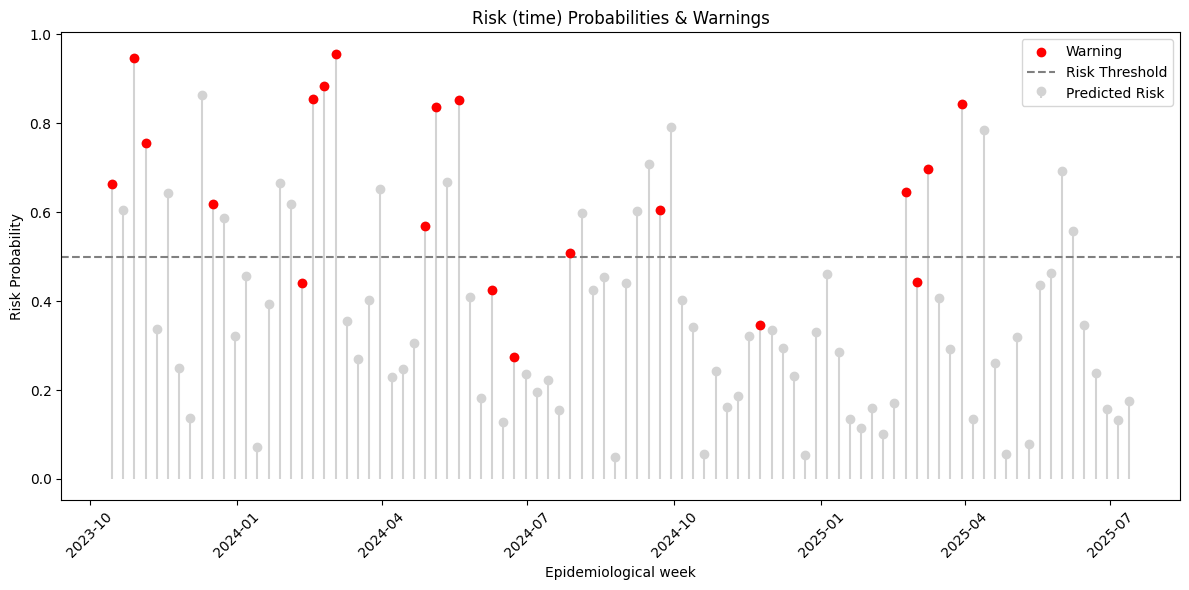

In [31]:
set_muni = final_result2[final_result2.co_ibge == '292740']

set_muni['epidemi_cal_start'] = pd.to_datetime(set_muni['epidemi_cal_start'])

plt.figure(figsize=(12, 6))
plt.stem(set_muni['epidemi_cal_start'], set_muni['risk_probs_time'],
         basefmt=" ", linefmt='lightgray', markerfmt='o', label='Predicted Risk')

plt.scatter(set_muni.loc[set_muni['aviso_aesop_ivas'] == 1, 'epidemi_cal_start'],
            set_muni.loc[set_muni['aviso_aesop_ivas'] == 1, 'risk_probs_time'],
            color='red', label='Warning', zorder=3)

plt.axhline(0.5, color='gray', linestyle='--', label='Risk Threshold')
plt.xticks(rotation=45)
plt.title('Risk (time) Probabilities & Warnings')
plt.xlabel('Epidemiological week')
plt.ylabel('Risk Probability')
plt.legend()
plt.tight_layout()
plt.grid(False)
plt.show()

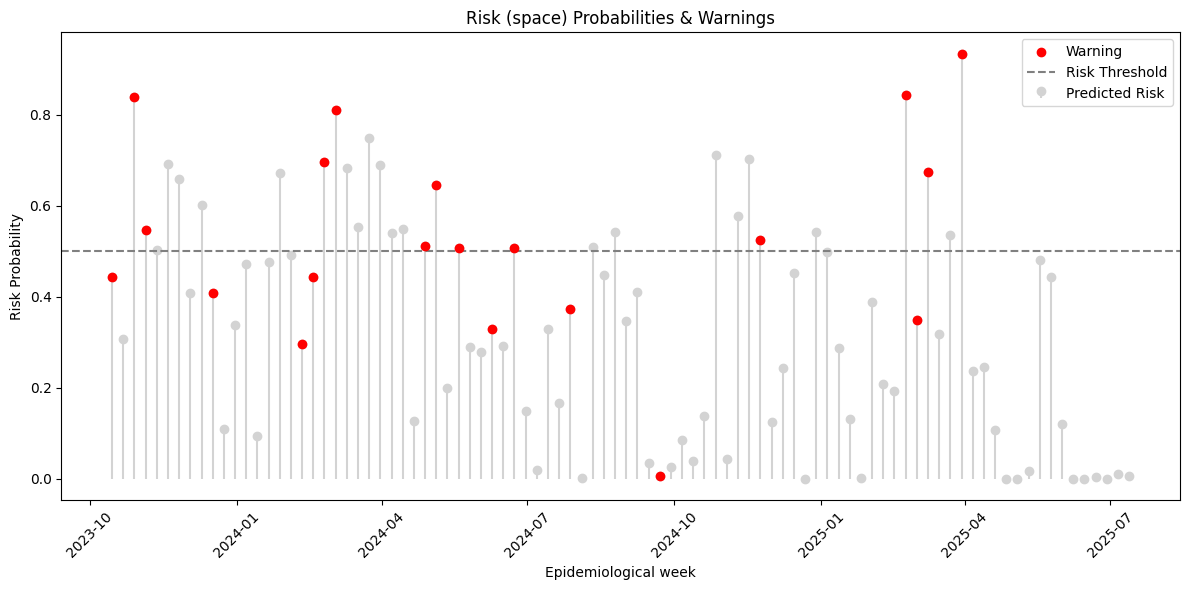

In [32]:
plt.figure(figsize=(12, 6))
plt.stem(set_muni['epidemi_cal_start'], set_muni['risk_probs_space'],
         basefmt=" ", linefmt='lightgray', markerfmt='o', label='Predicted Risk')

plt.scatter(set_muni.loc[set_muni['aviso_aesop_ivas'] == 1, 'epidemi_cal_start'],
            set_muni.loc[set_muni['aviso_aesop_ivas'] == 1, 'risk_probs_space'],
            color='red', label='Warning', zorder=3)

plt.axhline(0.5, color='gray', linestyle='--', label='Risk Threshold')
plt.xticks(rotation=45)
plt.title('Risk (space) Probabilities & Warnings')
plt.xlabel('Epidemiological week')
plt.ylabel('Risk Probability')
plt.legend()
plt.tight_layout()
plt.grid(False)
plt.show()

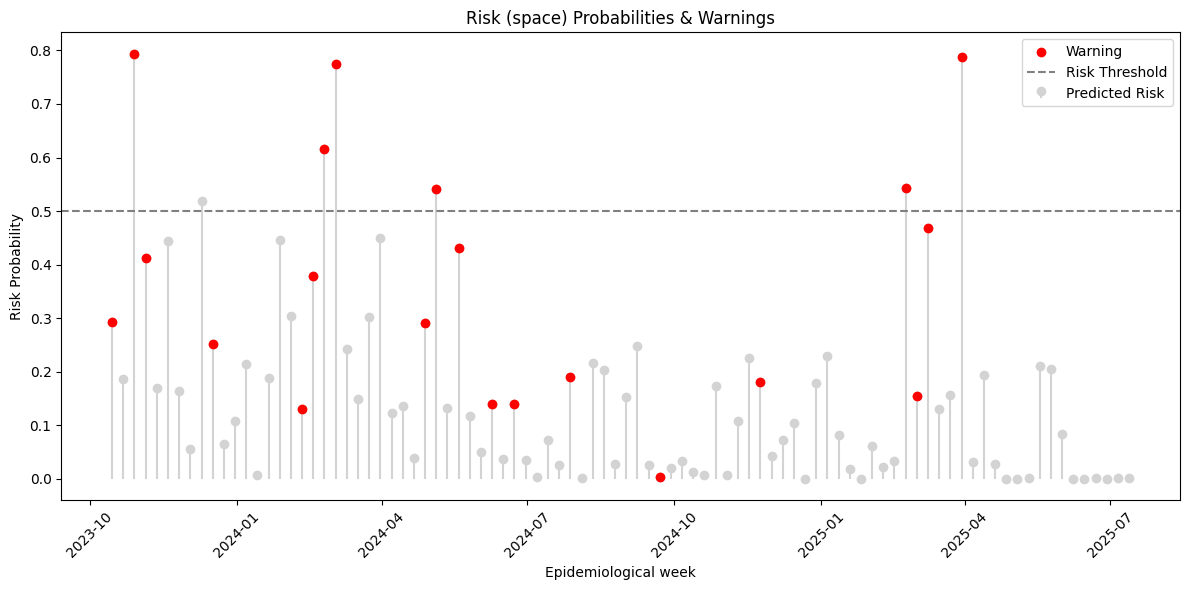

In [33]:
plt.figure(figsize=(12, 6))
plt.stem(set_muni['epidemi_cal_start'], set_muni['risk_prob_com'],
         basefmt=" ", linefmt='lightgray', markerfmt='o', label='Predicted Risk')

plt.scatter(set_muni.loc[set_muni['aviso_aesop_ivas'] == 1, 'epidemi_cal_start'],
            set_muni.loc[set_muni['aviso_aesop_ivas'] == 1, 'risk_prob_com'],
            color='red', label='Warning', zorder=3)

plt.axhline(0.5, color='gray', linestyle='--', label='Risk Threshold')
plt.xticks(rotation=45)
plt.title('Risk (space) Probabilities & Warnings')
plt.xlabel('Epidemiological week')
plt.ylabel('Risk Probability')
plt.legend()
plt.tight_layout()
plt.grid(False)
plt.show()

In [35]:
#final_result2.risk_prob_com.describe()

In [36]:
#final_result2[final_result2.risk_prob_com >= 0.9][['nm_municipio','year_week','aviso_aesop_ivas','risk_probs_time','risk_probs_space','risk_prob_com']]

In [37]:
#final_result2[(final_result2.year_week == '2025-28') & (final_result2.risk_prob_com >= 0.6)][['nm_municipio','year_week','aviso_aesop_ivas','risk_probs_time','risk_probs_space','risk_prob_com']]

In [21]:
#dta = final_result2[(final_result2.risk_probs_time >= 0.5) & (final_result2.risk_probs_space >= 0.9)][['nm_municipio','year_week','aviso_aesop_ivas','risk_probs_time','risk_probs_space']]

In [142]:
#print(classification_report(y, y_pred))

In [22]:
#data[(data.risk_probs >= 0.9) & (data.aviso_aesop_ivas == 1)][['nm_municipio',
#        'year_week',  'aviso_aesop_ivas', 
#        'dqi', 'prob_gro_trend_ivas', 'privacao',
#        'num_viz_aviso', 'num_paths_covered', 'risk_probs',
#       'aviso_aesop_pred']]

In [121]:
# --- Load shapefile of Brazilian municipalities ---

#gdf = gpd.read_file("/opt/storage/raw/aesop/visualization/shape_file_muni/BR_Municipios_2022.shp")  
# --- Merge risk data with geodata ---
#gdf = gdf.assign(co_ibge7 = gdf['CD_MUN'].astype(str))  # Standard IBGE code column
#data = data.assign(co_ibge7 = data['co_ibge7'].astype(str))
#merged = gdf.merge(data[['co_ibge7', 'aviso_aesop_ivas', 'risk_probs']], on="co_ibge7", how="left")

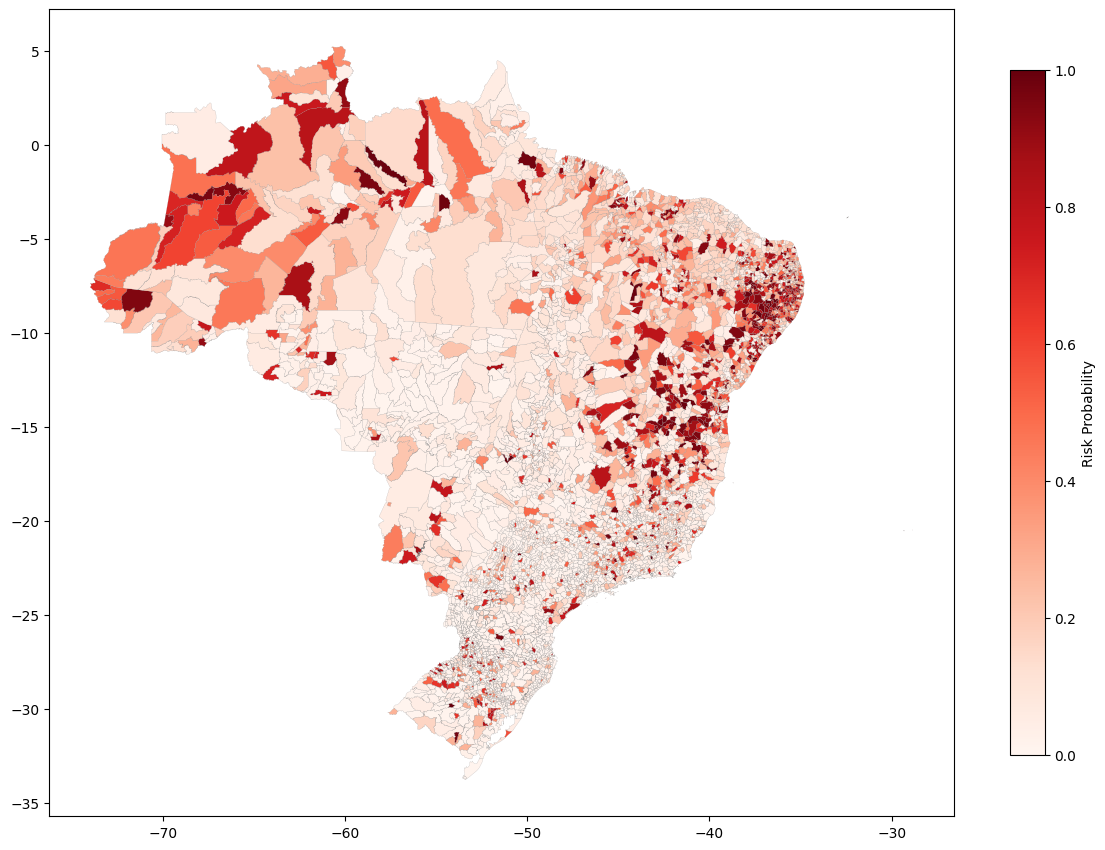

In [122]:
# --- Plotting ---
#fig, ax = plt.subplots(1, 1, figsize=(12, 14))

# 1. Plot all municipalities, coloring by risk
#merged.plot(
#    column='risk_probs',
 #   cmap='Reds',
 #  linewidth=0.1,
#    edgecolor='grey',
 #   legend=True,
 #   vmin=0,                # Set the color scale min
  #  vmax=1,                # Set the color scale max
 #   legend_kwds={
 #       'label': "Risk Probability",
 #       'shrink': 0.5,     # Reduce height of the colorbar (0.0 to 1.0)
 #       'orientation': 'vertical'
 #   },
 #   ax=ax
#)

# 2. Highlight municipalities with aviso_aesop_ivas == 1
#pins = merged[merged['aviso_aesop_ivas'] == 1]
#pins.plot(ax=ax, color='blue', markersize=5, marker='o', label='Aviso AESOP')


# 3. Customize
#ax.set_title("Brazilian Municipalities: Risk Levels and AESOP Warnings", fontsize=14)
#ax.axis('off')
#plt.legend(loc='lower left')

#plt.tight_layout()
#plt.show()
